# NBA FEATURES SELECTION FOR INVESTMENT DECISION

This analysis is based upon the "nba_dataset.csv". Link below 

https://github.com/MEMAUDATA/memaudata.github.io/blob/main/datasets/nba_dataset.csv

Two questions here : 
1) Identify the best features for investment decision and develop a ML model
2) Create a web app with the previous model. This app will run locally.

NV, Toulouse, octobre,2024

# Install all required librairies from requirements.txt

In [ ]:
pip install -r requirements.txt # type: ignore

# Import librairies

In [8]:
# For preprocessing
import numpy as np
import pandas as pd
import seaborn as sns
import joblib as jb 
from matplotlib import pyplot as plt
from scipy import stats as stats

In [9]:
# For modelisation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, RandomizedSearchCV,GridSearchCV
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_classif,chi2


# PANDAS WARNINGS

In [10]:
pd.options.mode.chained_assignment = None

 # Load data and do a simple vizualisation step before preprocessing

In [27]:
# Load dataset
df1 = pd.read_csv("datasets/nba_dataset.csv") # warning mac vs windows .// ou .\\

Make a copy of the imported dataframe to work on it in order to avoid issues that need to be adressed by reloading the original csv file that could take a while for big csv file. 

In [34]:
# backup
df = df1.copy()

In [35]:
# Display all columns
pd.set_option("display.max.columns", None)

# shape dataset
df.shape
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         1340 non-null   object 
 1   GP           1340 non-null   int64  
 2   MIN          1340 non-null   float64
 3   PTS          1340 non-null   float64
 4   FGM          1340 non-null   float64
 5   FGA          1340 non-null   float64
 6   FG%          1340 non-null   float64
 7   3P Made      1340 non-null   float64
 8   3PA          1340 non-null   float64
 9   3P%          1329 non-null   float64
 10  FTM          1340 non-null   float64
 11  FTA          1340 non-null   float64
 12  FT%          1340 non-null   float64
 13  OREB         1340 non-null   float64
 14  DREB         1340 non-null   float64
 15  REB          1340 non-null   float64
 16  AST          1340 non-null   float64
 17  STL          1340 non-null   float64
 18  BLK          1340 non-null   float64
 19  TOV   

In [36]:
df.head(3)

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,1.6,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,2.6,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,0.9,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0


# Define independant and dependants variables

This dataset contains 21 columns. The question on investment decision is based upon the column "Target_5YRS" which is, here, our dependant variable (supervided ML).

The remaining columns should be carrefully analyzed for potential data reduction and model optimisation.

Target_5YRS = 0 => No investment
Target_5YRS = 1 => investment


# Start data preprocessing

Duplicates / outliers / Nan values

In [37]:
# Remove duplicates : Keep first player if multiple players
df = df.drop_duplicates(subset='Name', keep="first", inplace=False)
df.shape
# reset index
df = df.reset_index(drop=True)

1339 - 1294 => 45 duplicates !

In [39]:
# create a specific column with target and values
target_col = df['TARGET_5Yrs']
name_col    = df['Name']

# Labels and data with target for preprocessing
labels  = df.drop(['TARGET_5Yrs','Name'],axis=1).columns.values
df      = df.drop(['TARGET_5Yrs','Name'],axis=1)
df      = pd.DataFrame(df)

# print df
print(df)

      GP   MIN  PTS  FGM  FGA   FG%  3P Made  3PA   3P%  FTM  FTA   FT%  OREB  \
0     36  27.4  7.4  2.6  7.6  34.7      0.5  2.1  25.0  1.6  2.3  69.9   0.7   
1     35  26.9  7.2  2.0  6.7  29.6      0.7  2.8  23.5  2.6  3.4  76.5   0.5   
2     74  15.3  5.2  2.0  4.7  42.2      0.4  1.7  24.4  0.9  1.3  67.0   0.5   
3     58  11.6  5.7  2.3  5.5  42.6      0.1  0.5  22.6  0.9  1.3  68.9   1.0   
4     48  11.5  4.5  1.6  3.0  52.4      0.0  0.1   0.0  1.3  1.9  67.4   1.0   
...   ..   ...  ...  ...  ...   ...      ...  ...   ...  ...  ...   ...   ...   
1289  80  15.8  4.3  1.6  3.6  43.3      0.0  0.2  14.3  1.2  1.5  79.2   0.4   
1290  68  12.6  3.9  1.5  4.1  35.8      0.1  0.7  16.7  0.8  1.0  79.4   0.4   
1291  43  12.1  5.4  2.2  3.9  55.0      0.0  0.0   0.0  1.0  1.6  64.3   1.5   
1292  52  12.0  4.5  1.7  3.8  43.9      0.0  0.2  10.0  1.2  1.8  62.5   0.2   
1293  47  11.7  4.4  1.6  4.4  36.9      0.4  1.3  33.3  0.7  1.0  67.3   0.2   

      DREB  REB  AST  STL  

In [40]:
print(labels)

['GP' 'MIN' 'PTS' 'FGM' 'FGA' 'FG%' '3P Made' '3PA' '3P%' 'FTM' 'FTA'
 'FT%' 'OREB' 'DREB' 'REB' 'AST' 'STL' 'BLK' 'TOV']


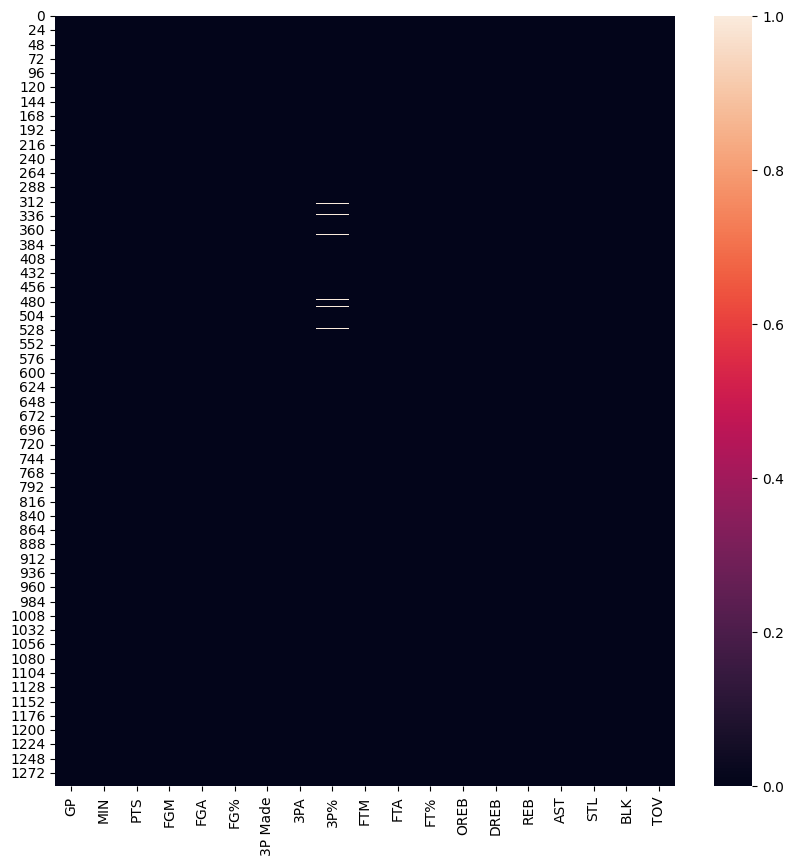

In [41]:
# Plot the entire data with heatmap from seaborn to try to look at valuable column
plt.figure(figsize=(10,10))
sns.heatmap(df.isna()) # 1 = empty
plt.show()

<Figure size 640x480 with 0 Axes>

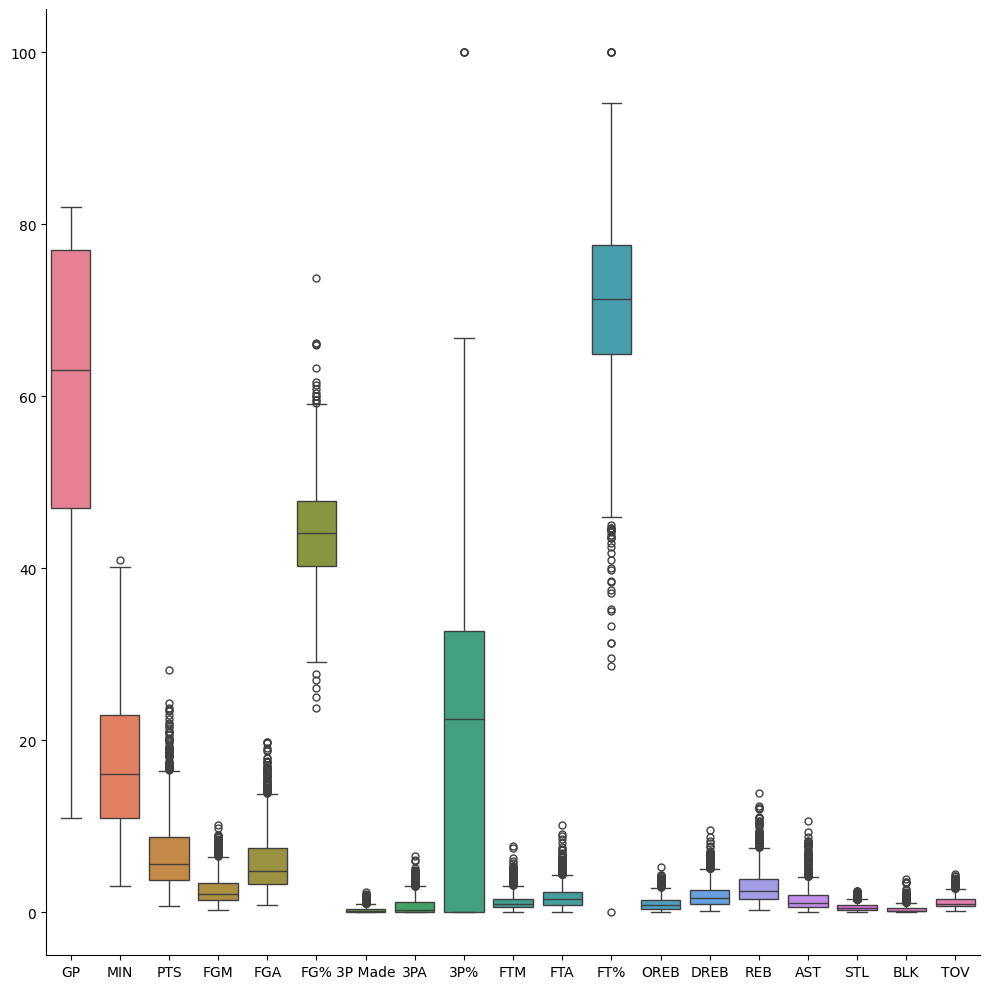

In [43]:
# Group visualization
plt.figure()
sns.catplot(data=df, kind="box",height = 10)
plt.show()

In [ ]:
# Plot column data to find outliers
for i in df.columns:
    #if col > 0:
        plt.figure()
        sns.boxplot(df[i])
        plt.show()


In [14]:
# Add target colon to df to remove outliers identification scores
df["target"]    = target_col

# OUTLIERS FOR THE ENTIRE DATASET

In [ ]:
# choice between Zscore / mean +/- + STD / IQR ( last one is more robust) 
# Calculate Q1 and Q3
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)

# Calculate the IQR#
IQR = Q3 - Q1

upper = Q3 + (1.5 * IQR)
lower = Q1 - (1.5 * IQR)


# outlier data
out= df[(df< upper) & (df>lower)]


# Remove outliers with the added target col created earlier
print(df.shape)
dfwo = df[((df< upper) & (df>lower)).all(axis=1)]
print(dfwo.shape)





In [ ]:
dfwo.describe()

# OUTLIERS BY COLUMNS

In [17]:
# Remove outliers by columns (done it 7 times) untill shape does not change anymore


#for k in df.columns:


    #Q1 = df[k].quantile(0.25)
    #Q3 = df[k].quantile(0.75)

    # Calculate the IQR#
    #IQR = Q3 - Q1

    # limits
    #upper = Q3 + (1.5 * IQR)
    #lower = Q1 - (1.5 * IQR)

    #df = df[(df[k]> lower)& (df[k] < upper)] 
    #df = df.shape[0]

In [18]:
# Resest index
dfwo.index  = range(len(dfwo.index))

In [ ]:
# Group visualization
plt.figure()
sns.catplot(data=dfwo, kind="box",height = 10)
plt.show

Nan  values ?

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(dfwo.isna()) # 1 = empty
plt.show()

In [ ]:
# replace nan values by Zeros !! Why not , probably better than remove the entire column
# remove target col
dfwo_target_col = dfwo["target"]
dfwo = dfwo.drop(["target"],axis=1).values # .values to transform from DataFrame to np.array 
print(type(dfwo))
print(dfwo)

In [ ]:
# Replace NaN values : NEED NP_ARRAY NOT DATAFRAME
for x in np.argwhere(np.isnan(dfwo)):
        dfwo[x]=0.0 
print(dfwo) 

In [ ]:
# Go back to dataframe
dfwo = pd.DataFrame(data = dfwo,columns = labels)
# Add target column
dfwo["target"] = dfwo_target_col
print(dfwo)

In [ ]:
# final clean dataset
clean_dataset = dfwo 
print(type(clean_dataset))

# save data set with joblib
jb.dump(clean_dataset, "clean_dataset.sav") 


# cleanset = new df without outliers/ nan values / duplicates and an updated target col

# PLOTS TO VISUALIZE DATA

In [25]:
# Load clean_dataset
loaded_model    = jb.load("clean_dataset.sav")

In [ ]:
# backup cleanset for plotting purposes
pp = loaded_model.copy()
pp.shape

In [27]:
# remove target column for plotting purposes
pp_target_col  = pp['target']
pp             = pp.drop("target",axis=1)

Visualization per groupe but not the same scales therefore try to zscore pp dataset

In [ ]:
# Group visualization
plt.figure()
sns.catplot(data=pp, kind="box",height = 4)
plt.show

zcore_pp = pp.apply(stats.zscore)
plt.figure()
sns.catplot(data=zcore_pp, kind="box",height = 4)
plt.show

# Still some outliers after data reduction but NEED some data for model prediction

Link between variables

In [ ]:
plt.figure(figsize=(5,5))
corr_values = pp.corr()
corr_heatmap = sns.heatmap(corr_values, xticklabels=df.columns, yticklabels=df.columns)
plt.show()

In [ ]:
for j in pp.columns:
    x_vect   = np.arange(0,pp.shape[0]) 
    y_vect   = pp[j]
    hue_vect = pp_target_col
    labels
    f, axes = plt.subplots(1, 2)
    plt.title(f'{j}')
    sns.kdeplot(data=pp, x=y_vect,hue=pp_target_col,ax = axes[0],palette="crest",alpha=.5,fill=True)
    sns.scatterplot(data=pp,x=x_vect, y=y_vect,hue=pp_target_col,ax = axes[1],legend=False,palette="crest",alpha=.5)
    plt.show()


From now , keep all datas. Probably the model selection will help us to restrain the dataset

# FIND MODEL PREDICTION

Split train and test set using the clean dataset loaded from folder

In [31]:
# load cleanset to have a nice clean start
clean_dataset    = jb.load('clean_dataset.sav')

In [ ]:
df = clean_dataset.copy()
print(df)

In [33]:
def prepare_data_for_modelisation(df):

    target  = df['target'].to_numpy()
    labels  = df.drop(['target'],axis=1).columns.values
    df      = df.drop(['target'],axis=1)
    data    = df.to_numpy()

    return  data,target

In [34]:
# For score_classifier function
data_pp, target_pp    = prepare_data_for_modelisation(df)

# MODEL PREDICTION = > OBJECTIVE :  IMPROVE FINAL RECALL SCORE 

Recall scare => lowest False negative  (on a confusion matrix) => model correctly identifying True Positives

Before model optimization and features selection we will use the provided function

Define classifiers

In [35]:
SVM             = make_pipeline(MinMaxScaler(),SVC(random_state=0))
KNN             = make_pipeline(MinMaxScaler(),KNeighborsClassifier(5))
Randomforest    = make_pipeline(RandomForestClassifier(random_state=0)) # Normalization not necessarily need it for trees
Adaboost        = make_pipeline(AdaBoostClassifier(algorithm="SAMME",random_state=0))# avoid warning
GNB             = make_pipeline(MinMaxScaler(),GaussianNB())


dict_of_models  = {"SVM" : SVM,
                  "KNN" : KNN,
                  "Randomforest" : Randomforest,
                  "Adaboost" : Adaboost,
                  'GNB':GNB}


Test score_classifieron the entire clean_dataset

In [36]:
def score_classifier(dataset,classifier,labels):

    """
    performs 3 random trainings/tests to build a confusion matrix and prints results with precision and recall scores
    :param dataset: the dataset to work on
    :param classifier: the classifier to use
    :param labels: the labels used for training and validation
    :return:
    """

    kf = KFold(n_splits=3,random_state=50,shuffle=True) # bootstraping
    confusion_mat = np.zeros((2,2))
    recall = 0
    for training_ids,test_ids in kf.split(dataset):
        training_set = dataset[training_ids]
        training_labels = labels[training_ids]
        test_set = dataset[test_ids]
        test_labels = labels[test_ids]
        classifier.fit(training_set,training_labels)
        predicted_labels = classifier.predict(test_set)
        confusion_mat+=confusion_matrix(test_labels,predicted_labels)
        recall += recall_score(test_labels, predicted_labels)
    recall/=3
    print('mean recall out of 3 Kflod splits : ' , recall)
    #print(classification_report(test_labels, predicted_labels))
   

In [ ]:
# Loop over score_classifier
for clf_name, clf in dict_of_models.items():
   
    print('-----' , clf_name ,'-----')
    score_classifier(data_pp, clf, target_pp)

Based on score_classifier function => choose best algorithm that maximizes recall score

Split data

In [38]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

Prepare for future modelisation

In [39]:
X_train, Y_train    = prepare_data_for_modelisation(trainset)
X_test, Y_test      = prepare_data_for_modelisation(testset)

In [ ]:
print(X_train.shape)
print(X_test.shape)


Normalize X_train and X_test data

In [41]:
scaler          = MinMaxScaler() # to save it later
X_train         = scaler.fit_transform(X_train)
X_test          = scaler.transform(X_test) 

Model optimization / Hyperparameters fine tuning / features selection

In [ ]:
model_selected      = SVC()
model_selected.fit(X_train, Y_train)
Y_pred              = model_selected.predict(X_test)
recall              = recall_score(Y_test, Y_pred)
print(recall)

Hyperparameters fine tuning

In [ ]:
model_to_optimize = make_pipeline(SVC()) 
hyper_parameters = {'svc__gamma':['auto','scale'],
                    'svc__C' : [0.1,1,10,20,100] , 
                    'svc__kernel':['rbf','linear','sigmoid','poly'],
                    'svc__degree':[2,3,4]} 

grid = RandomizedSearchCV(model_to_optimize, hyper_parameters,scoring='recall',cv=3, n_iter=20)
grid.fit(X_train,Y_train)
print(grid.best_estimator_)

Model optimized based upon Hyperparameters

In [ ]:
# Pipeline(steps=[('svc', SVC(C=0.1, degree=4, gamma='auto', kernel='poly'))]) => Recall of 1 => Too perfect ?

model_optimized      = grid.best_estimator_
model_optimized.fit(X_train, Y_train)
Y_pred              = model_optimized.predict(X_test)
recall              = recall_score(Y_test, Y_pred)
print(recall)

Overfitting ??

Features selection and plot using SelectKBest

In [ ]:
features        =  df.drop(["target"],axis=1)
bestfeatures    = SelectKBest(score_func=f_classif) # choose from figure
data_trim       = bestfeatures.fit_transform(X_train, Y_train)
filter          = bestfeatures.get_support()
print(bestfeatures.scores_)

In [ ]:
plt.figure(figsize=(15, 6))
sns.barplot(x=features.columns,y=bestfeatures.scores_,hue=features.columns,palette="crest",legend=False)
plt.title("Features")
plt.show()


Choose K for SelectKbest

In [ ]:
features            = df.drop(["target"],axis=1)
bestfeatures        = SelectKBest(score_func=f_classif,k=3) # choose from figure
data_trim           = bestfeatures.fit_transform(X_train, Y_train)
filter              = bestfeatures.get_support()

selected_features   = features.columns[filter]
print("selected features : ", list(selected_features))

# REDUCE CLEAN_DATASET TO OPTIMIZE MODEL

In [ ]:
reduce_dataset = df[selected_features]
reduce_dataset["target"] = df["target"]
print(reduce_dataset)

Split reduce data again 

In [90]:
trainset_reduce_data, testset_reduce_data = train_test_split(reduce_dataset, test_size=0.2, random_state=0)

In [91]:
# rd for reduced_daraset
X_train_rd, Y_train_rd    = prepare_data_for_modelisation(trainset_reduce_data)
X_test_rd, Y_test_rd      = prepare_data_for_modelisation(testset_reduce_data)

Data normalization

In [92]:
scaler              = MinMaxScaler() # to save it later
X_train_rd          = scaler.fit_transform(X_train_rd)
X_test_rd           = scaler.transform(X_test_rd) 

Test model again

In [ ]:
model_optimized      = grid.best_estimator_
#model_optimized      = model_selected
model_optimized.fit(X_train_rd, Y_train_rd)
Y_pred              = model_optimized.predict(X_test_rd)
recall              = recall_score(Y_test_rd, Y_pred)
print(recall)

# SAVE FINAl OPTIMIZED MODEL WITH RECALL = 1

In [ ]:
# %% save model with joblib 
jb.dump(scaler, "scaler.sav") 
jb.dump(model_optimized,'nba_model_optimzed.sav')

Test some predictions

In [ ]:
X           = [[30,1,0.5]]
X_scaled    = scaler.transform(X)
Y           = model_optimized.predict(X_scaled)
print(Y)